In [1]:
from __future__ import division, print_function

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append('/zfsauton/home/dsutherl/scratch/caffe/python')
import caffe

In [5]:
from IPython.display import HTML, display, Image

In [6]:
import os

In [7]:
# img = os.path.join('yemen_odo_user_images', os.listdir('yemen_odo_user_images/')[3])
img = 'flag2.jpg'

In [8]:
with open('format.html') as f:
    display(HTML(f.read().replace('__IMAGE_PATH_HERE__', 'flag2.jpg')))

In [9]:
# flag cutout
coords = [[262,3],[294,34],[337,45],[394,76],[380,248],[367,287],[381,346],[303,267],[268,206],[264,167],[217,130],[180,107],[173,80],[201,15],[208,0],]

In [10]:
import random
with open('all_images') as f:
    filenames = [s.strip() for s in f]
random.shuffle(filenames)

In [11]:
import cv2

In [12]:
backgrounds = []

for l in filenames:
    dst = cv2.imread(l)

    #discard images with extreme height to width ratio
    yd, xd = dst.shape[:2]
    dratio = yd / xd
    if dratio > 5.0 or dratio < 0.2:
        print('{}: bad ratio {}'.format(l, dratio))
        continue

    backgrounds.append(dst)
    if len(backgrounds) >= 5000:
        break

In [13]:
from compositing import generate_composites

In [14]:
%%time
composites = list(generate_composites(img, backgrounds[:1000], np.array(coords),
                                      ))#randomize_loc=True, rand_scale=True))

CPU times: user 980 ms, sys: 375 ms, total: 1.35 s
Wall time: 1.35 s


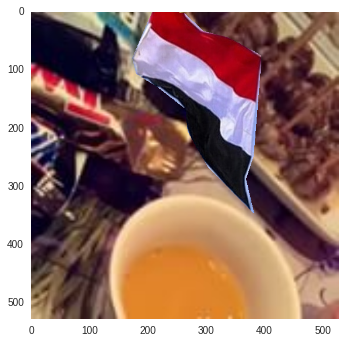

In [15]:
plt.imshow(cv2.cvtColor(composites[0], cv2.COLOR_BGR2RGB))
plt.grid(False)

In [16]:
from extract_features import get_features, load_net

In [17]:
%%time
layers = ['fc6', 'fc7']
batch_size = 2000
net, transformer = load_net(layers=layers, batch_size=batch_size)

CPU times: user 687 ms, sys: 801 ms, total: 1.49 s
Wall time: 1.52 s


In [18]:
%%time
embeddings = list(get_features(
    [(c / 255)[:, :, (2,1,0)] for c in composites],
    layers=layers, batch_size=batch_size, net=net, transformer=transformer))
mean_embedding = np.mean(embeddings, axis=0)

CPU times: user 2min 46s, sys: 16.2 s, total: 3min 2s
Wall time: 1min 29s


In [19]:
orig_embedding = next(get_features(
    [caffe.io.load_image(img)],
    layers=layers, batch_size=batch_size, net=net, transformer=transformer))

In [20]:
import requests

In [21]:
with open('all_images') as f:
    file_names = [s.strip() for s in f]

In [ ]:
orig_neighbors = requests.post('http://low1:5000/query/10',
      json={'features': [float(f) for f in orig_embedding]})

In [ ]:
mean_neighbors = requests.post('http://low1:5000/query/10',
      json={'features': [float(f) for f in mean_embedding]})

In [ ]:
for i in orig_neighbors:
    display(file_names[i])
    display(Image(file_names[i]))

In [ ]:
for i in mean_neighbors:
    display(file_names[i])
    display(Image(file_names[i]))